#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала, импортируем все необходимые для дальнейшей работы инструменты

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

Взглянем на предложенные данные

In [76]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индесы(даты) и проверим правильность сортировки

In [78]:
df.sort_index(inplace=True)

In [79]:
df.index.is_monotonic

True

Вглянем на визуализированные данные 

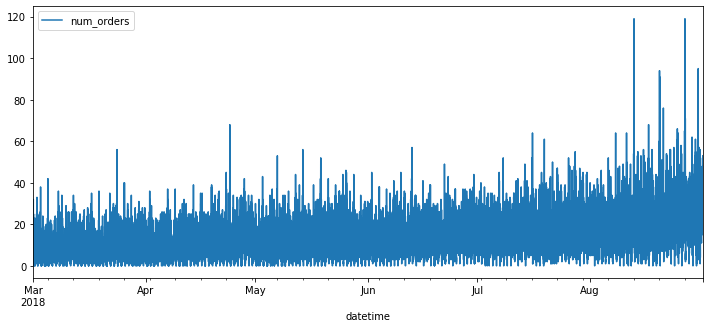

In [80]:
df.plot(figsize=(12,5))

График вряд-ли можно назвать читаемым, чтобы на нём можно было хоть что-нибудь увидеть прибегнем к ресемплированию данных и проверим, сколько заказов приходило в час

In [81]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Любопытно будет пронаблюдать тренд на сезонность, для этого декомпозируем данные по сезонам и взглянем на получившиеся графики

In [82]:
decomposed = seasonal_decompose(df)

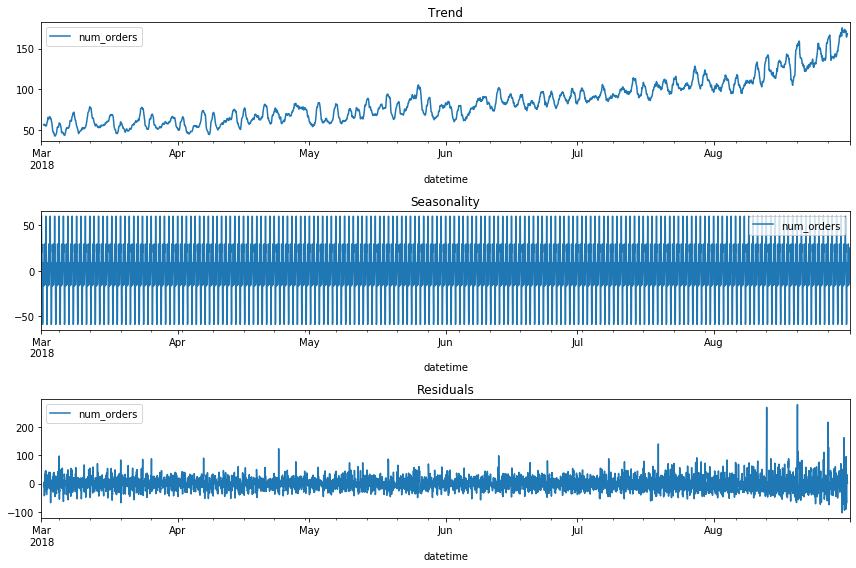

In [83]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим поближе график seasonal, выберем интервал, который четче обозначит зависимость

Text(0.5, 1.0, 'Seasonality')

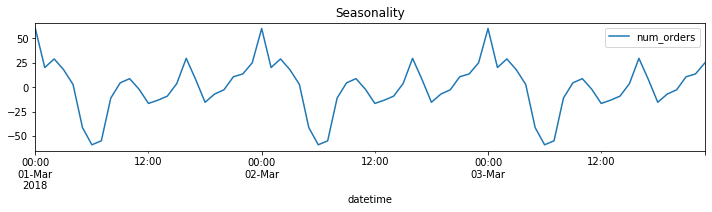

In [84]:
plt.figure(figsize=(12, 8))
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')


По графику сезонности можно отметить переодичность: пик загрузки приходится в полночь, минимум в 6 утра. Также наблюдается локальный максимум днем. 

По полученным данным видно, что в данном случае мы работаем с нестационарным временным рядом - данные в неём меняются с высокой частотой

## Анализ

Напишем функцию, которая преобразует наши данные в фичи, с которыми будут работать модели ниже.

In [85]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data['lag_' + str(i)] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df, 2, 24)

In [86]:
df

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean,std
datetime,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000,65.948143
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667,63.268908
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667,63.105487


Разделим датафрейм на 3 части: обучающую, вилидационную и тестовую выбороки в пропорциях 3:1:1

In [87]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.fillna(0)

In [88]:
train.shape, test.shape

((3974, 7), (442, 7))

Определим наши фичи и искомый признак

In [89]:
train_features = train.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_target = test['num_orders']

Приведем к балансу данные с помощью метода StandartScaller. Обучим его только на тренировочной выборке, а затем трансформируем все фичи для корректной работы предсказательных моделей.

Так же, обернем в функцию задачу по вычислению RSME

In [18]:
def RMSE(target, predict):
    return mean_squared_error(target, predict) ** 0.5

Таким образом, мы привели наши данные к более прогнозируемому, стандартному временному ряду, а так же, дополнили данные фичами, которые будет использовать модель в процессе обучения

## Обучение

Для начала определим метрику, по которой будем оценивать качество наших моделей. Для задач регрессии подойдет среднеквадратичное отклонение.

In [19]:
score = make_scorer(RMSE, greater_is_better=False)

### Модель линейной регрессии

Первым делом проверим модель линейной регрессии. Она практически не имеет параметров для настройки, однако имеет крайне высокую скорость работы.

In [20]:
LinearReg_model = LinearRegression()

In [21]:
%%time
LinearReg_model.fit(train_features, train_target)

CPU times: user 2.42 ms, sys: 285 µs, total: 2.7 ms
Wall time: 1.93 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Высокая скорость работы не сказалась на качестве результата, на валидационной выборке контролируемая метрика дала результат почти в два раза меньший порогового.

### Стохастический градиентный бустинг

Следующим по очереди идет стохастический градиентный бустинг

In [22]:
SGD_model = SGDRegressor(random_state=42, shuffle=False)
SGD_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Эта модель уже имеет достаточное колчество настраиваемых параметров, однако чтобы избежать длительного подрбора гиперпараметров и обучения модели, с помощью метода GridSearchCV попробуем найти оптимальные значения лишь у двух гиперпараметров модели. Оценивать качество подобранных параметров будем как раз по метрике RMSE с помощью метода make_scorer, который мы задали выше

In [23]:
param_grid = {'alpha' : [0.0001, 0.001],
              'max_iter': [1000, 10_000, 100_000],
              'eta0': [0.1, 0.01, 0.001]}

In [24]:
split_index = TimeSeriesSplit(n_splits = 8)

In [25]:
print(split_index)

TimeSeriesSplit(max_train_size=None, n_splits=8)


In [26]:
grid_cv = GridSearchCV(SGD_model, param_grid, scoring=score, cv = split_index)

In [27]:
%%time
grid_cv.fit(train_features, train_target)

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.6 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=42,
                                    shuffle=False, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001], 'eta0': [0.1, 0.01, 0.001],
                         'max_iter': [1000, 10000, 100000]},
             pre_dispatch='2*n

Итого, время подбора параметров составило 39,7 секунд, оптимальные параметры модели приведены в выводе ниже. Их мы используем для работы с основной моделью и получения предсказаний далее.

In [28]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-31.155237913680356
{'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 10000}


In [29]:
SGD_model = SGDRegressor(alpha = 0.001 , max_iter = 1000.0, eta0 = 0.001, shuffle=False, random_state=42)

In [30]:
%%time
SGD_model.fit(train_features, train_target)

CPU times: user 33.7 ms, sys: 0 ns, total: 33.7 ms
Wall time: 32.8 ms


SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000.0,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Результат очень близок с результату линейной регрессии, однако скорость предсказания существенно выше. 

### XGBRegressor

Посмотрим на модель XGBRegressor'а. Повторим все вышеописанные шаги в той же последовательности и взглянем на финальный результат

In [31]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0)
XGBRegressor_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [32]:
param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.3, 0.5]}

In [33]:
grid_cv = GridSearchCV(XGBRegressor_model, param_grid, scoring=score, cv = split_index)

In [34]:
%%time
grid_cv.fit(train_features, train_target)

CPU times: user 3min 4s, sys: 1.09 s, total: 3min 5s
Wall time: 3min 8s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthr...
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
        

In [35]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-25.0288516894619
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [36]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42, max_depth = 6 , 
                                  n_estimators = 100, learning_rate = 0.5)

In [37]:
%%time
XGBRegressor_model.fit(train_features, train_target)

CPU times: user 1.63 s, sys: 8.6 ms, total: 1.64 s
Wall time: 1.61 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

Данная модель показала в три раза лучший результат, нежели предыдущие, однако имеет маленькую скорость предсказания и достаточно ощутимое время обучения

### CatBoost

Проверим, как справится с задачей CatBoost

In [39]:
CatBoost_model = CatBoostRegressor(random_state=42)

In [40]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'iterations': [50, 100, 200]}

In [41]:
grid_cv = GridSearchCV(CatBoost_model, param_grid, scoring=score, cv = split_index)

In [42]:
%%time
grid_cv.fit(train_features, train_target, verbose = 100)

0:	learn: 28.4994390	total: 47.6ms	remaining: 2.33s
49:	learn: 18.4608888	total: 143ms	remaining: 0us
0:	learn: 28.5808043	total: 700us	remaining: 34.3ms
49:	learn: 19.9223403	total: 37.5ms	remaining: 0us
0:	learn: 29.5449988	total: 935us	remaining: 45.9ms
49:	learn: 21.0281731	total: 154ms	remaining: 0us
0:	learn: 30.3275424	total: 829us	remaining: 40.6ms
49:	learn: 21.6946719	total: 28.1ms	remaining: 0us
0:	learn: 32.0394661	total: 948us	remaining: 46.5ms
49:	learn: 22.9914823	total: 117ms	remaining: 0us
0:	learn: 32.5298378	total: 1.06ms	remaining: 52.1ms
49:	learn: 23.1705866	total: 128ms	remaining: 0us
0:	learn: 33.2645570	total: 1.16ms	remaining: 56.9ms
49:	learn: 23.5769892	total: 327ms	remaining: 0us
0:	learn: 34.7903649	total: 1.04ms	remaining: 51.2ms
49:	learn: 24.3913495	total: 373ms	remaining: 0us
0:	learn: 28.0484200	total: 2.23ms	remaining: 109ms
49:	learn: 16.0770590	total: 29.4ms	remaining: 0us
0:	learn: 28.1072750	total: 857us	remaining: 42ms
49:	learn: 17.8393165	tota

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f623f92cb10>,
             iid='warn', n_jobs=None,
             param_grid={'iterations': [50, 100, 200],
                         'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [2, 4, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [43]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-24.680046974552223
{'iterations': 200, 'learning_rate': 0.1, 'max_depth': 4}


In [44]:
CatBoost_model = CatBoostRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.5, iterations = 200)

In [45]:
%%time
CatBoost_model.fit(train_features, train_target, verbose=10)

0:	learn: 31.0938166	total: 2.15ms	remaining: 428ms
10:	learn: 23.0427572	total: 66.4ms	remaining: 1.14s
20:	learn: 20.7650728	total: 269ms	remaining: 2.3s
30:	learn: 19.5292733	total: 454ms	remaining: 2.48s
40:	learn: 18.6676501	total: 648ms	remaining: 2.51s
50:	learn: 17.7595892	total: 757ms	remaining: 2.21s
60:	learn: 17.0732914	total: 945ms	remaining: 2.15s
70:	learn: 16.4397608	total: 1.14s	remaining: 2.06s
80:	learn: 15.9705566	total: 1.33s	remaining: 1.95s
90:	learn: 15.5085039	total: 1.44s	remaining: 1.72s
100:	learn: 15.0769133	total: 1.63s	remaining: 1.6s
110:	learn: 14.6812289	total: 1.82s	remaining: 1.46s
120:	learn: 14.2490658	total: 2.02s	remaining: 1.32s
130:	learn: 13.9052184	total: 2.21s	remaining: 1.16s
140:	learn: 13.5921711	total: 2.41s	remaining: 1.01s
150:	learn: 13.3039396	total: 2.6s	remaining: 845ms
160:	learn: 12.9498016	total: 2.79s	remaining: 676ms
170:	learn: 12.6415495	total: 2.9s	remaining: 491ms
180:	learn: 12.2792558	total: 3.09s	remaining: 324ms
190:	l

CatBoost справился хуже чем XGBRegressor, но показывает не менее достойный результат как по итоговой метрике, так и по времени. Однако, стоит заметить, что время подбора параметров примерно в два раза большще, чем аналогичное у  XGBRegressor

### LGBMRegressor

Последний в нашем тесте будет LGBM Regressor

In [46]:
LGBM_model = LGBMRegressor(random_state=42)
LGBM_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [50, 100, 200]}

In [48]:
grid_cv = GridSearchCV(LGBM_model, param_grid, scoring=score, cv = split_index)

In [49]:
%%time
grid_cv.fit(train_features, train_target)

CPU times: user 1min 41s, sys: 1.18 s, total: 1min 42s
Wall time: 1min 44s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [2, 4, 6],
    

In [50]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-24.585940673821128
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [51]:
LGBM_model = LGBMRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.5, n_estimators = 100)

In [52]:
%%time
LGBM_model.fit(train_features, train_target)

CPU times: user 636 ms, sys: 6.22 ms, total: 642 ms
Wall time: 604 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Данная модель показала отличный результат по метрике, а так же лучшее общее время среди бустингов.

## Тестирование

Перейдём к тестированию наших моделей на тестовой выборке. Напоминаю, что итоговое значение метрики не болжно превышать 48 для того, чтобы результат можно было считать приемлимым

### Тестирование линейной регрессии

Пойдем в том же порядке, в котором и обучали модели, а значит первый кандидат - линейная регрессия

In [53]:
%%time
pred_test_LinReg = LinearReg_model.predict(test_features)

CPU times: user 342 µs, sys: 19 µs, total: 361 µs
Wall time: 300 µs


In [54]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test_LinReg).round(2))

RMSE на тестовой выборке:  51.65


Значение итоговой метрики близко к пороговому, однако, всё-таки, меньше его, значит такая модель удовлетворяет поставленным выше условиям

### Тест стохастического бустинга

Посмотрим на результат стохастического бустинга

In [55]:
%%time
pred_test_SGD = SGD_model.predict(test_features)

CPU times: user 0 ns, sys: 371 µs, total: 371 µs
Wall time: 340 µs


In [56]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test_SGD).round(2))

RMSE на тестовой выборке:  51.58


Качество предсказания незначительно улучшилось, а время практически не изменилось. Результат не то, чтобы отличный, однако вполне себе удовлетворительный.

### Тест XGBRegressor'а

Далее идёт модель XGBRegressor

In [57]:
%%time
pred_test_XGB = XGBRegressor_model.predict(test_features)

CPU times: user 10.4 ms, sys: 334 µs, total: 10.7 ms
Wall time: 3.17 ms


In [58]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test_XGB).round(2))

RMSE на тестовой выборке:  48.42


Время работы несколько увеличилось, однако оно всё еще достаточно мало, чтобы человек мог заметить разницу между первыми двумя моделями и этой. Тем не менее, качество предсказания заметно улучшилось

### Тест CatBoost'a

Следующий на очереди модель CatBoost

In [59]:
%%time
pred_test_CB = CatBoost_model.predict(test_features)

CPU times: user 5.68 ms, sys: 42 µs, total: 5.72 ms
Wall time: 2.47 ms


In [60]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test_CB).round(2))

RMSE на тестовой выборке:  44.34


Качество предсказания несколько хуже, чем у предыдущей модели при таком же относительно маленьком времени предсказания

### Тест LGBMRegressor'а

Последней рассмотренной моделью был LGBMRegressor

In [61]:
%%time
pred_test_LGBM = LGBM_model.predict(test_features)

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.36 ms


In [62]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test_LGBM).round(2))

RMSE на тестовой выборке:  46.23


Как и в ситуации с CatBoost'ом, модель показала относительно неплохой, но чуть худший результат по сравнении с XGBRegressor'ом.

### Итоговый результат

Сведём итоговые результаты в общую таблицы для простоты и наглядности оценки работы моделей

In [63]:
pivot_result=pd.DataFrame({'Модель':['LinearRegression', 'SGDRegressor', 'XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
 'Скорость подбора гиперпараметров':['Гиперпараметры для подбора отсутствуют', '20,5сек', '4мин 16сек', '9 мин 56сек', '3мин 21сек'],
 'Скорость обучения':['39,1 мсек', '53мсек', '2,27сек', '5,62сек', '1,07сек'],
 'Скорость предсказания': ['1,06мсек', '83,8мсек', '87,3мсек', '2,61мсек', '90,4мсек'],
 'Качество предсказания на тестовой выборке(RMSE)': ['53,36', '53,23', '51,49', '45,18', '46,71']})
pivot_result

,Модель,Скорость подбора гиперпараметров,Скорость обучения,Скорость предсказания,Качество предсказания на тестовой выборке(RMSE)
0,LinearRegression,Гиперпараметры для подбора отсутствуют,"39,1 мсек","1,06мсек","53,36"
1,SGDRegressor,"20,5сек",53мсек,"83,8мсек","53,23"
2,XGBRegressor,4мин 16сек,"2,27сек","87,3мсек","51,49"
3,CatBoostRegressor,9 мин 56сек,"5,62сек","2,61мсек","45,18"
4,LGBMRegressor,3мин 21сек,"1,07сек","90,4мсек","46,71"


Получается следующая картина: если для нас важна общая скорость, то оптимальным вариантом станет выбор модели линейной регрессии, так как по всем скоростям она показала наиболее оптимальный результат при приемлимом уровне итоговой метрики. Если же мы боремся исключительно за качество итоговой модели, то в таком случае лучшим выбором станет LGBMRegressor, так как он  лидирует по уровню контролируемой метрики требуя, однако при этом, больше времени на подбор параметров модели.

Для полноты картины и понимания, где именно и какого порядка произошли отклонения между реальными значенями и результатами работы моделей. Для начала сравним все модели.

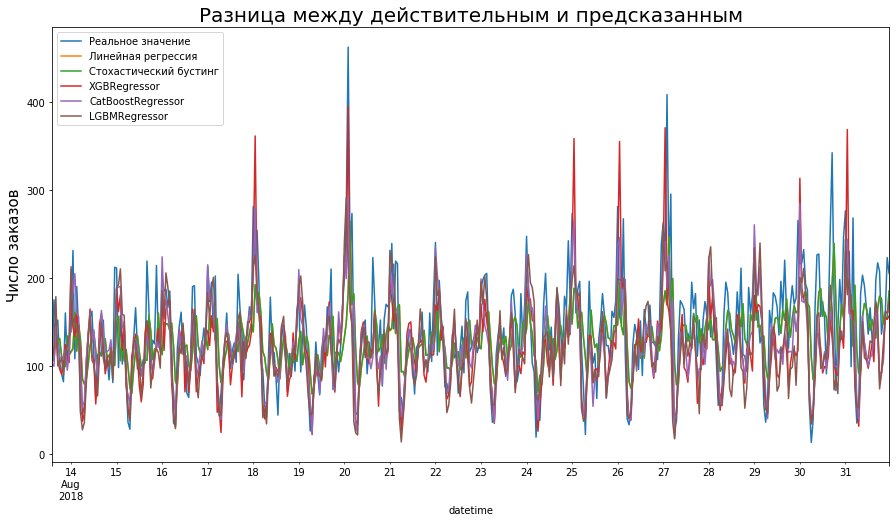

In [64]:
plt.figure(figsize=(15, 8))
plt.title('Разница между действительным и предсказанным', fontsize=20)
plt.ylabel('Число заказов', fontsize=15)
test_target.plot(ax=plt.gca())
pd.Series(pred_test_LinReg, index = test_target.index).plot(ax=plt.gca())
pd.Series(pred_test_SGD, index = test_target.index).plot(ax=plt.gca())
pd.Series(pred_test_XGB, index = test_target.index).plot(ax=plt.gca())
pd.Series(pred_test_CB, index = test_target.index).plot(ax=plt.gca())
pd.Series(pred_test_LGBM, index = test_target.index).plot(ax=plt.gca())
plt.legend(['Реальное значение','Линейная регрессия', 'Стохастический бустинг', 'XGBRegressor' , 'CatBoostRegressor', 'LGBMRegressor'], loc = 2)
plt.show()

Посмторим на характер графиков для моделей линейной регрессии и LGBMRegressor

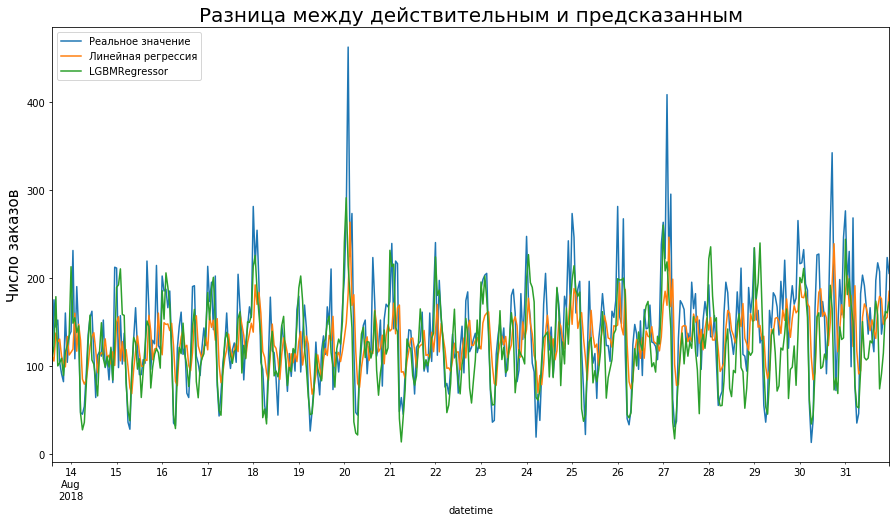

In [65]:
plt.figure(figsize=(15, 8))
plt.title('Разница между действительным и предсказанным', fontsize=20)
plt.ylabel('Число заказов', fontsize=15)
test_target.plot(ax=plt.gca())
pd.Series(pred_test_LinReg, index = test_target.index).plot(ax=plt.gca())
pd.Series(pred_test_LGBM, index = test_target.index).plot(ax=plt.gca())
plt.legend(['Реальное значение','Линейная регрессия', 'LGBMRegressor'], loc = 2)
plt.show()

Сравним теперь реальные значения и предсказания рекомендованных моделей по отдельности

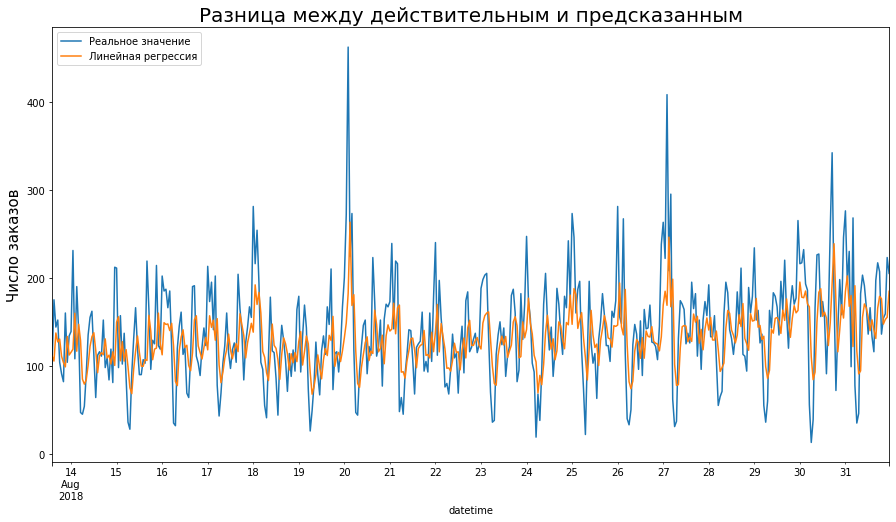

In [66]:
plt.figure(figsize=(15, 8))
plt.title('Разница между действительным и предсказанным', fontsize=20)
plt.ylabel('Число заказов', fontsize=15)
test_target.plot(ax=plt.gca())
pd.Series(pred_test_LinReg, index = test_target.index).plot(ax=plt.gca())
plt.legend(['Реальное значение','Линейная регрессия'], loc = 2)
plt.show()

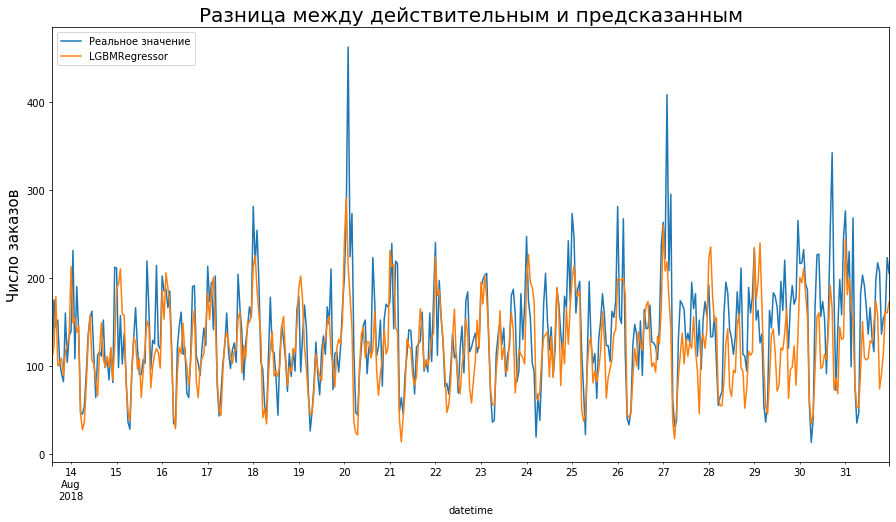

In [67]:
plt.figure(figsize=(15, 8))
plt.title('Разница между действительным и предсказанным', fontsize=20)
plt.ylabel('Число заказов', fontsize=15)
test_target.plot(ax=plt.gca())
pd.Series(pred_test_LGBM, index = test_target.index).plot(ax=plt.gca())
plt.legend(['Реальное значение', 'LGBMRegressor'], loc = 2)
plt.show()

Как видно из полученных графиков, наибольшее несоответствие и, как следствие, набегающая ошибка и рост метрики RSME происходят в точках, которые можно назвать "ваыбросами" - происходит скачок числа заказов. Также, можно отметить рост тренда реальной величины, тогда как очевидного роста тренда в предсказаниях модели не наблюдается.

## Вывод

По результатам проделанной работы можно сделать слудующие выводы:
- данные поступили в нормальном виде, предобработка как таковая не потребовалась
- изначально в данных временной ряд представлял из себя труднопрогнозируемый нестационарный ряд, который, в последствии, был приведен к стационарному
- исследовано 5 моделей
- линейная регрессия и стохастический бустинг очень быстрые методы и показывают неплохой результат. Однако, если для нас принципиальна скорость работы, то лучший вариант для решения такой задачи будет как раз линейная регрессия
- XGBRegressor имеет высокую точность предсказаний, но относительно невысокую скорость работы.
- CatBoostRegressor имеет худшую скорость работы в поставленной задаче, но высокую точность
- LGBMRegressor имеет крайне высокую скорость обучения и предсказания, и кроме того дает наименьшую ошибку предсказания. Эту модель рекомендуется использовать, если для заказчика принципиална скорость работы модели.